In [1]:
import pandas as pd
import os
import requests, zipfile, io
import numpy as np


# Managers

In [2]:
managers = pd.read_csv("data/ipo_managers.csv", header=[0,1])
managers

Trade           Unnamed: 1_level_0 Unnamed: 2_level_0  \
          Date                       Issuer             Symbol   
0      1/17/20                       I-Mab                IMAB   
1      1/17/20                       LIZHI                LIZI   
2      1/17/20  Phoenix Tree Holdings Ltd.                 DNK   
3      1/17/20          Velocity Financial                 VEL   
4      1/24/20           Gores Holdings IV               GHIVU   
...        ...                          ...                ...   
3628   12/8/00      Specialty Laboratories                  SP   
3629   12/8/00          W.P. Stewart & Co.                 WPL   
3630  12/11/00                     Gemplus                GEMP   
3631  12/12/00                       GenVec               GNVC   
3632  12/15/00        Resources Connection                RECN   

                                        Lead/Joint-Lead    Offer  Opening  \
                                               Managers    Price    Price   
0                                       Jefferies/ CICC  $14.00   $14.75    
1                              Credit Suisse/ Citigroup  $11.00   $11.03    
2                 Citigroup/ Credit Suisse/ J.P. Morgan  $13.50   $13.50    
3     Wells Fargo Securities/ Citigroup/ JMP Securities  $13.00   $13.85    
4                              Deutsche Bank Securities  $10.00   $10.52    
...                                                 ...      ...      ...   
3628                                      Merrill Lynch  $16.00   $21.94    
3629                               Goldman Sachs/Lazard  $20.00   $22.06    
3630                         Credit Suisse First Boston  $10.69   $12.00    
3631                                        J.P. Morgan   $9.50   $10.56    
3632                         Credit Suisse First Boston  $12.00   $13.63    

      1st Day            $ Change             Star Unnamed: 11_level_0  
        Close % Px Chng   Opening    Close Ratings           Performed  
0     $12.75      -8.93%   $0.75   ($1.25)       2                 NaN  
1     $11.63       5.73%   $0.03    $0.63        1                 NaN  
2     $13.50       0.00%   $0.00    $0.00        1                 NaN  
3     $13.51       3.92%   $0.85    $0.51        1                 NaN  
4     $10.45       4.50%   $0.52    $0.45        1                 NaN  
...       ...        ...      ...      ...     ...                 ...  
3628  $23.31      45.70%   $5.94    $7.31        3                 NaN  
3629  $24.50      22.50%   $2.06    $4.50        2                 NaN  
3630  $13.38      25.12%   $1.31    $2.69        1                 NaN  
3631   $9.88       3.95%   $1.06    $0.38        2                 NaN  
3632  $16.00      33.33%   $1.63    $4.00        2                 NaN  

[3633 rows x 12 columns]

In [3]:
managers.columns = ['_'.join(col) for col in managers.columns.values]


In [4]:
managers.columns = managers.columns.str.replace(' ','_').str.lower()

In [5]:
managers.rename(columns={
    'unnamed:_1_level_0_issuer':'company_name', 
    'unnamed:_2_level_0_symbol': 'ticker',
    'lead/joint-lead__managers': 'all_managers',
    'price': 'opening_price',
    'unnamed:_11_level_0_performed': 'performed'},
                inplace=True)

In [6]:
# turn multi-valued managers cells into multi-row, single-valued
managers_columns = list(managers.columns)
managers_columns.remove('all_managers')
managers_columns

['trade_date',
 'company_name',
 'ticker',
 'offer_price',
 'opening_price',
 '1st_day_close',
 '1st_day_%_px_chng_',
 '$_change_opening',
 '$_change_close',
 'star_ratings',
 'performed']

In [7]:
managers.dropna(subset=['all_managers'], inplace=True)
managers['all_managers'] = managers['all_managers'].map(lambda x: x.replace("/"," ,"))

managers['all_managers'] = managers['all_managers'].map(lambda x: x.split(","))
managers['all_managers']

0                                     [Jefferies ,  CICC]
1                            [Credit Suisse ,  Citigroup]
2             [Citigroup ,  Credit Suisse ,  J.P. Morgan]
3       [Wells Fargo Securities ,  Citigroup ,  JMP Se...
4                              [Deutsche Bank Securities]
                              ...                        
3628                                      [Merrill Lynch]
3629                             [Goldman Sachs , Lazard]
3630                         [Credit Suisse First Boston]
3631                                        [J.P. Morgan]
3632                         [Credit Suisse First Boston]
Name: all_managers, Length: 3633, dtype: object

In [8]:
managers_melt = managers.all_managers.apply(pd.Series) \
    .merge(managers, right_index = True, left_index = True) \
    .drop(["all_managers"], axis = 1) \
    .melt(id_vars = managers_columns , value_name = "managers") 


In [9]:
managers_melt.dropna(subset=['managers'], inplace=True)

In [10]:
managers_melt

,trade_date,company_name,ticker,offer_price,opening_price,1st_day_close,1st_day_%_px_chng_,$_change_opening,$_change_close,star_ratings,performed,variable,managers
0,1/17/20,I-Mab,IMAB,$14.00,$14.75,$12.75,-8.93%,$0.75,($1.25),2,NaN,0,Jefferies
1,1/17/20,LIZHI,LIZI,$11.00,$11.03,$11.63,5.73%,$0.03,$0.63,1,NaN,0,Credit Suisse
2,1/17/20,Phoenix Tree Holdings Ltd.,DNK,$13.50,$13.50,$13.50,0.00%,$0.00,$0.00,1,NaN,0,Citigroup
3,1/17/20,Velocity Financial,VEL,$13.00,$13.85,$13.51,3.92%,$0.85,$0.51,1,NaN,0,Wells Fargo Securities
4,1/24/20,Gores Holdings IV,GHIVU,$10.00,$10.52,$10.45,4.50%,$0.52,$0.45,1,NaN,0,Deutsche Bank Securities
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44636,7/1/15,CNX Coal Resources LP,CNXC,$15.00,$15.00,$15.41,2.73%,$0.00,$0.41,1,NaN,12,Nomura
44687,10/14/15,First Data,FDC,$16.00,$16.39,$15.75,-1.56%,$0.39,($0.25),1,NaN,12,Wells Fargo Securities
44716,1/23/14,Santander Consumer USA Holdings,SC,$24.00,$25.75,$25.28,5.33%,$1.75,$1.28,2,NaN,12,Wells Fargo Securities
47244,2/6/20,PPD,PPD,$27.00,$31.00,$30.00,11.11%,$4.00,$3.00,3,NaN,13,Baird


# Age

In [11]:
age = pd.read_csv("data/ipo_age.csv")

In [12]:
age.columns = age.columns.str.replace(' ','_').str.lower()

array([[<AxesSubplot:title={'center':'offer_date'}>,
        <AxesSubplot:title={'center':'post-issue_shares'}>]], dtype=object)

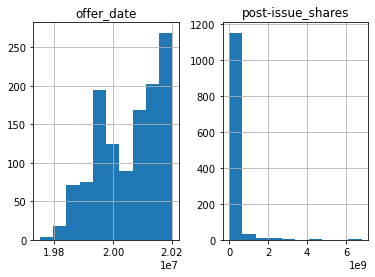

In [13]:
age['post-issue_shares'] = age['post-issue_shares'].replace('.',0).astype(int)
age[age['post-issue_shares']>0].hist()

In [14]:
age['internet'].value_counts()


0    11163
1      818
9       18
.        7
Name: internet, dtype: int64

array([[<AxesSubplot:title={'center':'offer_date'}>,
        <AxesSubplot:title={'center':'post-issue_shares'}>]], dtype=object)

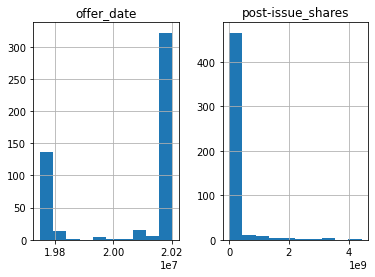

In [15]:
messy_columns = age[(age["vc_dummy"].isin(['9','.']))
   | (age["dual"].isin(['9','.']))
   | (age["rollup"].isin(['.']))
   | (age["internet"].isin(['9','.']))]

messy_columns[messy_columns["rollup"].isin(['9','.'])].hist()

<br>**vc_dummy** - is a dummy with 1 for VC and 2 for a subset of VC (growth capital)
<br>**dual** - dummy for multiple share class IPOs
<br>**rollup** - 0-1 dummy variable for whether the IPO was a rollup 
<br>**internet** - dummy with 1 if it is an internet-based  company 

<br>**will not drop any rows right away, until after the merge**

# Financial Data

In [16]:
# import financials -- all num.txt and sub.txt
years = list(range(2009,2021))
quarters = ['q1','q2','q3','q4']
filenames = ['num.txt','sub.txt']   
dataset = 'financial-statement-data-sets'
# 'pre.txt','tag.txt

def SEC_data(dataset,quarter,year,filename):
    url = f"https://www.sec.gov/files/dera/data/{dataset}/{year}{quarter}.zip"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()
    df = pd.read_csv(filename,sep="\t",dtype={"cik":str})
    return df

In [17]:
financials = []    
for year in years:
    for quarter in quarters:
        for filename in filenames:
            df = SEC_data(dataset,quarter, year, filename)
            financials.append(df)

/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (35) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [18]:
numi = []
subi = []
financials_all = []

for n in list(range(len(financials))):
    if n % 2 == 0:
        numi.append(n)
    else:  
        subi.append(n)
        
for n, s in zip(numi,subi):
    merged_df = financials[n].merge(financials[s][["adsh","cik","name","period","fy","fp","filed", "form","instance"]])
    financials_all.append(merged_df)

Filter for only 10-Ks only
<br> Companies have different FYs and larger companies take much longer to submit filings -- will not filter for quarter 

In [19]:
financials = pd.concat(financials_all)
financials.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105850078 entries, 0 to 2373223
Data columns (total 17 columns):
 #   Column    Dtype  
---  ------    -----  
 0   tag       object 
 1   version   object 
 2   coreg     object 
 3   ddate     object 
 4   qtrs      object 
 5   uom       object 
 6   value     float64
 7   footnote  object 
 8   adsh      object 
 9   cik       object 
 10  name      object 
 11  period    float64
 12  fy        float64
 13  fp        object 
 14  filed     object 
 15  form      object 
 16  instance  object 
dtypes: float64(3), object(14)
memory usage: 14.2+ GB


In [20]:
tags = pd.DataFrame(financials['tag'].value_counts())
tags[tags['tag']>=500000]

,tag
NetIncomeLoss,1219874
CashAndCashEquivalentsAtCarryingValue,1090750
OperatingIncomeLoss,905307
IncomeTaxExpenseBenefit,853246
StockholdersEquity,795342
Assets,698393
InterestExpense,673430
LiabilitiesAndStockholdersEquity,665961
EarningsPerShareBasic,659969
EarningsPerShareDiluted,639670


In [21]:
financials_tags = financials[financials["tag"].isin(["NetIncomeLoss",
                                                 "CashAndCashEquivalentsAtCarryingValue",
                                                 "OperatingIncomeLoss",
                                                 "StockholdersEquity",
                                                 "Assets",
                                                 
                                                 "LiabilitiesAndStockholdersEquity",
                                                 "LiabilitiesAndStockholdersEquity",
                                                 
                                                 "EarningsPerShareBasic",
                                                 "EarningsPerShareDiluted",
                                                 
                                                 "NetCashProvidedByUsedInOperatingActivities",
                                                 "NetCashProvidedByUsedInFinancingActivities",
                                                 
                                                 "RetainedEarningsAccumulatedDeficit",
                                                 "EarningsPerShareDiluted",
                                                 "CommonStockSharesAuthorized"
                                                 ])]

In [22]:
annual_raw = financials_tags[financials_tags["form"].isin(["10-K","20-K","40-K"])]


In [23]:
annual_raw.drop(annual_raw.columns[np.r_[7]], axis=1, inplace=True)


/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [24]:
annual_raw.drop_duplicates(inplace= True)

<ipython-input-24-f35c028b3ecf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annual_raw.drop_duplicates(inplace= True)


In [25]:
annual_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2393312 entries, 3481 to 2288717
Data columns (total 16 columns):
 #   Column    Dtype  
---  ------    -----  
 0   tag       object 
 1   version   object 
 2   coreg     object 
 3   ddate     object 
 4   qtrs      object 
 5   uom       object 
 6   value     float64
 7   adsh      object 
 8   cik       object 
 9   name      object 
 10  period    float64
 11  fy        float64
 12  fp        object 
 13  filed     object 
 14  form      object 
 15  instance  object 
dtypes: float64(3), object(13)
memory usage: 310.4+ MB


In [26]:
annual = annual_raw.pivot_table(values='value', 
                          index= ['version',
                                  'coreg',
                                  'ddate',
                                  'qtrs',
                                  'uom',
                                  'adsh',
                                  'cik',
                                  'name',
                                  'period',
                                  'fy',
                                  'fp',
                                  'filed',
                                  'form',
                                  'instance'],
                          columns = 'tag')


In [27]:
annual.reset_index(inplace=True)

In [28]:
annual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114475 entries, 0 to 114474
Data columns (total 26 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   version                                     114475 non-null  object 
 1   coreg                                       114475 non-null  object 
 2   ddate                                       114475 non-null  int64  
 3   qtrs                                        114475 non-null  int64  
 4   uom                                         114475 non-null  object 
 5   adsh                                        114475 non-null  object 
 6   cik                                         114475 non-null  object 
 7   name                                        114475 non-null  object 
 8   period                                      114475 non-null  float64
 9   fy                                          114475 non-null  float64
 

# Crowdfunding Data

In [29]:
# import crowdfunding -- 'FORM_C_SUBMISSION.tsv','FORM_C_DISCLOSURE.tsv'
quarters = ['q1_cf','q2_cf','q3_cf','q4_cf']
years = list(range(2017,2021))
dataset = 'crowdfunding-offerings-data-sets'

crowdfunding = []    
for year in years:
    for quarter in quarters:
        file_disc = f"{year}{quarter.capitalize()}/FORM_C_DISCLOSURE.tsv"
        file_issuer = f"{year}{quarter.capitalize()}/FORM_C_ISSUER_INFORMATION.tsv"        
        filenames =[file_disc,file_issuer]
        for filename in filenames:
            df = SEC_data(dataset, quarter, year, filename)
            crowdfunding.append(df)
 

In [30]:
disc_i = []
issuer_i = []
crowdfunding_all = []

for n in list(range(len(crowdfunding))):
    if n % 2 == 0:
        disc_i.append(n)
    else:  
        issuer_i.append(n)
        
for n, s in zip(disc_i,issuer_i):
    df = crowdfunding[n].merge(crowdfunding[s])
    crowdfunding_all.append(df)

In [31]:
crowdfunding = pd.concat(crowdfunding_all)

In [32]:
crowdfunding.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9553 entries, 0 to 1013
Data columns (total 51 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ACCESSION_NUMBER                9553 non-null   object 
 1   COMPENSATIONAMOUNT              7958 non-null   object 
 2   FINANCIALINTEREST               5716 non-null   object 
 3   SECURITYOFFEREDTYPE             7958 non-null   object 
 4   SECURITYOFFEREDOTHERDESC        3625 non-null   object 
 5   NOOFSECURITYOFFERED             6401 non-null   float64
 6   PRICE                           7300 non-null   float64
 7   PRICEDETERMINATIONMETHOD        4245 non-null   object 
 8   OFFERINGAMOUNT                  7958 non-null   float64
 9   OVERSUBSCRIPTIONACCEPTED        7958 non-null   object 
 10  OVERSUBSCRIPTIONALLOCATIONTYPE  7875 non-null   object 
 11  DESCOVERSUBSCRIPTION            4575 non-null   object 
 12  MAXIMUMOFFERINGAMOUNT           78

In [33]:
crowdfunding.drop(crowdfunding.columns[np.r_[30:45,46,48,49]], axis=1, inplace=True)

In [34]:
crowdfunding.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9553 entries, 0 to 1013
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ACCESSION_NUMBER                9553 non-null   object 
 1   COMPENSATIONAMOUNT              7958 non-null   object 
 2   FINANCIALINTEREST               5716 non-null   object 
 3   SECURITYOFFEREDTYPE             7958 non-null   object 
 4   SECURITYOFFEREDOTHERDESC        3625 non-null   object 
 5   NOOFSECURITYOFFERED             6401 non-null   float64
 6   PRICE                           7300 non-null   float64
 7   PRICEDETERMINATIONMETHOD        4245 non-null   object 
 8   OFFERINGAMOUNT                  7958 non-null   float64
 9   OVERSUBSCRIPTIONACCEPTED        7958 non-null   object 
 10  OVERSUBSCRIPTIONALLOCATIONTYPE  7875 non-null   object 
 11  DESCOVERSUBSCRIPTION            4575 non-null   object 
 12  MAXIMUMOFFERINGAMOUNT           78

In [35]:
crowdfunding.rename(columns={
    'ACCESSION_NUMBER':'accession_number',
    'COMPENSATIONAMOUNT': 'compensation_amount',
    'FINANCIALINTEREST': 'financial_interest',
    'SECURITYOFFEREDTYPE': 'security_offered_type',
    'SECURITYOFFEREDOTHERDESC': 'security_offered_other_desc',
    'NOOFSECURITYOFFERED':'no_of_security_offered', 
    'PRICE': 'price',
    'PRICEDETERMINATIONMETHOD': 'price_determination_method',
    'OFFERINGAMOUNT': 'offering_amount',
    'DESCOVERSUBSCRIPTION' : 'desc_over_subscription',
   
    'OVERSUBSCRIPTIONACCEPTED': 'oversubscription_accepted',    
    'OVERSUBSCRIPTIONALLOCATIONTYPE':'oversubscriptional_location_type', 
    'COMPENSATIONAMOUNT': 'des_cover_subscription',
    'MAXIMUMOFFERINGAMOUNT': 'maximum_offering_amount',
    'DEADLINEDATE': 'deadline_date',
    
    'CURRENTEMPLOYEES': 'current_employees',
    
    
    'TOTALASSETMOSTRECENTFISCALYEAR':'total_asset_most_recent_fiscalyear', 
    'TOTALASSETPRIORFISCALYEAR': 'total_asset_prior_fiscal_year',
    
    'CASHEQUIMOSTRECENTFISCALYEAR': 'cash_equi_most_recent_fiscal_year',
    'CASHEQUIPRIORFISCALYEAR': 'cash_equi_prior_fiscal_year',
    
    'ACTRECEIVEDRECENTFISCALYEAR': 'act_received_recent_fiscal_year',
    'ACTRECEIVEDPRIORFISCALYEAR':'act_received_prior_fiscal_year', 
    
    'SHORTTERMDEBTMRECENTFISCALYEAR': 'short_term_debt_m_recent_fiscal_year',
    'SHORTTERMDEBTPRIORFISCALYEAR': 'short_term_debt_prior_fiscal_year',
    
    'LONGTERMDEBTRECENTFISCALYEAR': 'long_term_debt_recent_fiscal_year',
    'LONGTERMDEBTPRIORFISCALYEAR': 'long_term_debt_prior_fiscal_year',    
    
    'REVENUEMOSTRECENTFISCALYEAR':'revenue_most_recent_fiscal_year', 
    'REVENUEPRIORFISCALYEAR': 'revenue_prior_fiscal_year',
    
    'COSTGOODSSOLDRECENTFISCALYEAR': 'cost_goods_sold_recent_fiscal_year',
    'COSTGOODSSOLDPRIORFISCALYEAR': 'cost_goods_sold_prior_fiscal_year',
    
    'TAXPAIDMOSTRECENTFISCALYEAR': 'tax_paid_most_recent_fiscal_year',
    
    'ZIPCODE':'zipcode', 
    'COMPANYNAME': 'company_name',
    'CRDNUMBER': 'financial_interest'
},
                inplace=True)

In [36]:
crowdfunding.columns

Index(['accession_number', 'des_cover_subscription', 'financial_interest',
       'security_offered_type', 'security_offered_other_desc',
       'no_of_security_offered', 'price', 'price_determination_method',
       'offering_amount', 'oversubscription_accepted',
       'oversubscriptional_location_type', 'desc_over_subscription',
       'maximum_offering_amount', 'deadline_date', 'current_employees',
       'total_asset_most_recent_fiscalyear', 'total_asset_prior_fiscal_year',
       'cash_equi_most_recent_fiscal_year', 'cash_equi_prior_fiscal_year',
       'act_received_recent_fiscal_year', 'act_received_prior_fiscal_year',
       'short_term_debt_m_recent_fiscal_year',
       'short_term_debt_prior_fiscal_year',
       'long_term_debt_recent_fiscal_year', 'long_term_debt_prior_fiscal_year',
       'revenue_most_recent_fiscal_year', 'revenue_prior_fiscal_year',
       'cost_goods_sold_recent_fiscal_year',
       'cost_goods_sold_prior_fiscal_year', 'tax_paid_most_recent_fiscal_year'

# Save Collected Data 

In [39]:
import joblib 
joblib.dump(crowdfunding,"crowdfunding.pkl")
joblib.dump(annual,"annual.pkl")
joblib.dump(managers_melt,"managers_melt.pkl")
joblib.dump(managers,"managers.pkl")
joblib.dump(age,"age.pkl")

['age.pkl']

In [40]:
ls


2017Q1_cf/             2019Q3_cf/             data/
2017Q2_cf/             2019Q4_cf/             data_collection.ipynb
2017Q3_cf/             2020Q1_cf/             data_merge.ipynb
2017Q4_cf/             2020Q2_cf/             managers.pkl
2018Q1_cf/             2020Q3_cf/             managers_melt.pkl
2018Q2_cf/             2020Q4_cf/             num.txt
2018Q3_cf/             2021Q1_cf/             pre.txt
2018Q4_cf/             age.pkl                readme.htm
2019Q1_cf/             annual.pkl             sub.txt
2019Q2_cf/             crowdfunding.pkl       tag.txt
